# Assignment 1 Homework 11

NOTE: this notebook is ran under python 2

Populating the interactive namespace from numpy and matplotlib


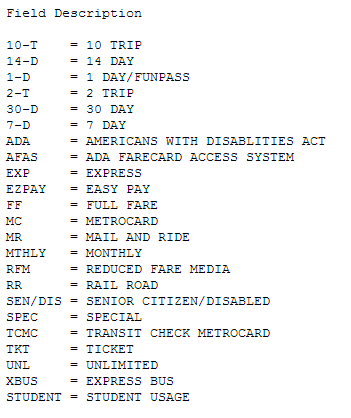

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

# Data Processing

**Reading the data**

In [2]:
mta = np.load('MTA_Fare.npy')

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [4]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


Note to self: There are 600 stations, each stations have 23 card types and 194 days. 

In other words: 600 arrays *23 and in each array there is 194 values

**Replacing -1 with NaN values in array**

In [5]:
# converting fare array from int32 into float so that 
# that I can replace -1 to with NaN later
# code credit @https://stackoverflow.com/questions/32207474/changing-numpy-array-to-float
mta_float = mta[:].astype(float)

In [6]:
# replacing -1 with NaN values
mta_float[mta_float == -1] = np.nan

In [7]:
mta_float

array([[[  5.69610000e+04,   6.47030000e+04,   6.80020000e+04, ...,
           3.65270000e+04,   3.39290000e+04,   3.68240000e+04],
        [  1.73200000e+03,   2.08300000e+03,   2.10700000e+03, ...,
           1.26400000e+03,   1.17200000e+03,   1.23800000e+03],
        [  2.03000000e+02,   2.76000000e+02,   2.45000000e+02, ...,
           1.86000000e+02,   1.67000000e+02,   1.67000000e+02],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [             nan,              nan,              nan, ...,
           1.12100000e+03,   1.37700000e+03,   7.12000000e+02]],

       [[  1.62100000e+04,   2.01790000e+04,   2.17690000e+04, ...,
                      nan,              nan,              nan],
        [  5.03000000e+02,   6.47000000e+02,   6.65000000e+0

**Setting up dates**

In [8]:
date_range = pd.date_range(start="2010-05-19", periods=194, freq='W-WED')

In [9]:
date_range

DatetimeIndex(['2010-05-19', '2010-05-26', '2010-06-02', '2010-06-09',
               '2010-06-16', '2010-06-23', '2010-06-30', '2010-07-07',
               '2010-07-14', '2010-07-21',
               ...
               '2013-11-27', '2013-12-04', '2013-12-11', '2013-12-18',
               '2013-12-25', '2014-01-01', '2014-01-08', '2014-01-15',
               '2014-01-22', '2014-01-29'],
              dtype='datetime64[ns]', length=194, freq='W-WED')

# Plotting the data to understand it better

**The non-log plot**

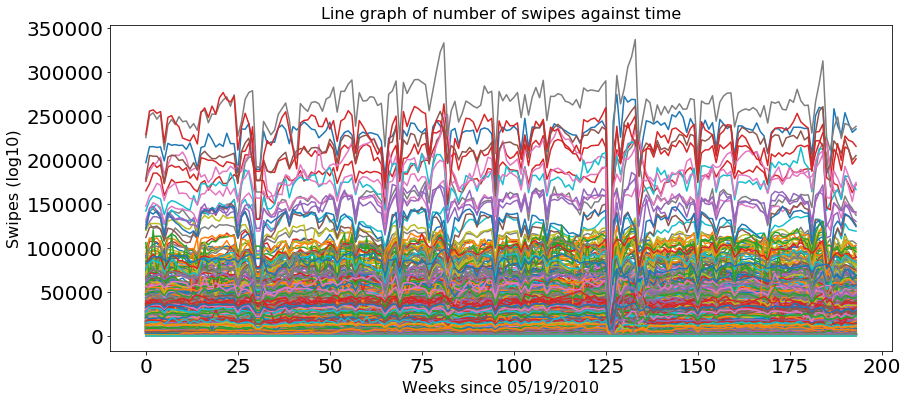

In [35]:
plt.figure(figsize=(14,6))
plt.title("Line graph of number of swipes against time", fontsize= 16)
plt.ylabel("Swipes (log10)", fontsize=16)
plt.xlabel("Weeks since 05/19/2010", fontsize=16)

for i in range(600):
    for j in range(23):
        plt.plot(mta[i][j])

Figure 1: Time series for all ride types and all stations. Most of the lines are visibly 'squished' at smaller values of swipes, implying that there are data lines that are much bigger in values. There are several time periods that seems to have a collective drop in swipes, such as the time period around 25 weeks, 100 weeks and 125 weeks since 05/21/2018.

**The Log10 plot**

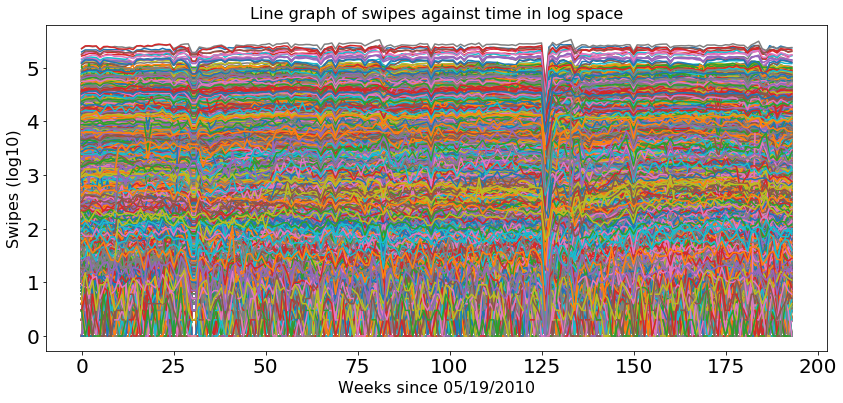

In [36]:
plt.figure(figsize=(14,6))
plt.title("Line graph of swipes against time in log space", fontsize= 16)
plt.ylabel("Swipes (log10)", fontsize=16)
plt.xlabel("Weeks since 05/19/2010", fontsize=16)

for i in range(600):
    for j in range(23):
        plt.plot(np.log10(mta[i][j]))

Figure 2: Time series for all ride types and all stations in semi-log space. Having treated the y-axis with log, the data lines are now evenly spread throughout the plot and now it is quite apparent that it all lines seems to have an obvious drop around 125th week since 05/21/2010. 

# Task 1

- Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
- Identify it and figure out what it is due to.

**EVENT DETECTION**

- idea is that we just need a one dimension data for each week
- then run a point of change to identify the week of interest
- and a threshold to prove that it is more than 3 sigmas

**Understanding the 3d array**

In [10]:
mta_float.shape

(600, 23, 194)

In [11]:
len(mta_float) #1st dimension- 600 arrays for each station

600

In [12]:
len(mta_float[0]) #2nd dimension- 23 sets of 600 arrays for each card type

23

In [13]:
len(mta_float[0][0]) #3rd dimension- 194 weeks or data points in the arrays

194

**Compressing 3d array into desired 1d**

In [14]:
mta_2d = np.nansum(mta_float, axis=0)
mta_2d.shape

(23, 194)

In [15]:
mta_weekly = np.nansum(mta_2d, axis=0)
len(mta_weekly)

194

**Applying 3sigma threshold for event detection**

In [16]:
print ("mean xxx by day {:.2f}".format(mta_weekly.mean()))
print ("stdev xxx by day {:.2f}".format(mta_weekly.std()))
thresholds = [mta_weekly.mean() + 3 * mta_weekly.std(), 
              mta_weekly.mean() - 3 * mta_weekly.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean xxx by day 29781349.87
stdev xxx by day 2983960.42
3-sigma thresholds 38733231.14 20829468.61


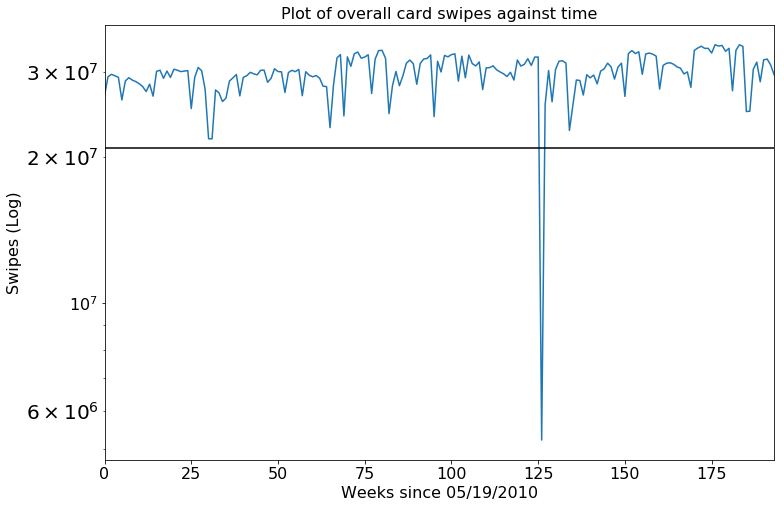

In [37]:
test = pd.DataFrame(data = mta_weekly) #converting to a pandas dataframe so as to plot threshold 

ax = test.plot(logy=True, figsize=(12,8), legend=False)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], color='k') #threshold plot

pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.ylabel("Swipes (Log)", fontsize=16)
pl.xlabel("Weeks since 05/19/2010", fontsize=16)
pl.title('Plot of overall card swipes against time', fontsize=16);

Figure 3:

**Point of Change**

In [20]:
def changeFinder(data):

    n = len(data)
    datamean = np.nanmean(data)
    datasqmean = np.nanmean(data**2)
    fac = datasqmean - datamean**2
    
    datacsum = np.nancumsum(data)
    datasum = datacsum[-1]

    ppoc = np.zeros(n) #container for point of change relative prob

    #online (iterative) search for point of change
    for m in range(n-1):
        pos = m + 1
        relativePosition = (pos) * (n - pos)
 
        Q = datacsum[m] - (datasum - datacsum[m]) #cumsum up to m - cumsum after
        
        U = -(datamean * (n - 2 * pos) + Q)**2 / (4.0 * relativePosition) + fac
       
        ppoc[m+1] = (-(n * 0.5 - 1) * np.log(n * U * 0.5) - 
                 0.5 * np.log(relativePosition))

    ppoc[0] = min(ppoc[1:])
    changePoint = np.argmax(ppoc)
    
    return {'pChange': ppoc, 
            'pointOfChange': changePoint + 1,
            'meanBefore': np.nanmean(data[:changePoint+1]), 
            'meanAfter': np.nanmean(data[(changePoint+1):])}

Since it has been observed that all the data series have a significant dip at the same time period, I will apply change finder to one series to identify the exact time period of the dip.

In [21]:
changeFinder(mta_float[0][0]) #to identify the point of change

{'meanAfter': 41294.615384615383,
 'meanBefore': 67437.259842519692,
 'pChange': array([-2321.60789022, -2315.22121932, -2317.61645854, -2318.19029593,
        -2318.1176969 , -2317.73797986, -2317.55191733, -2317.40784603,
        -2317.2134993 , -2316.85796941, -2316.56515516, -2316.14654228,
        -2315.87223621, -2316.08357246, -2316.08177361, -2316.28717369,
        -2316.52018029, -2316.91936915, -2317.37188305, -2317.74352846,
        -2317.94882565, -2318.32170298, -2318.60630669, -2318.95744856,
        -2319.21633775, -2319.39454997, -2319.67376256, -2319.77357612,
        -2319.87182791, -2319.99112867, -2320.15240389, -2320.29058437,
        -2320.42008782, -2320.40871195, -2320.62906338, -2320.93104709,
        -2321.19064571, -2321.31160404, -2321.41041135, -2321.47428869,
        -2321.54149483, -2321.58936848, -2321.60789022, -2321.53982383,
        -2321.51928479, -2321.51642423, -2321.46507072, -2321.42434915,
        -2321.24658476, -2321.11172059, -2321.05614066, 

In [22]:
date_range[127]

Timestamp('2012-10-24 00:00:00', freq='W-WED')

**The identified event is Hurricane Sandy as it occured from Oct 22 2012, in which metro services was suspended for a while for public safety**

# Task 2

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600.

Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

you should find the ride type that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type.

you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the number of rides near the beginning to the number of rides near the end of the time series.
notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

from the notes identification of trends = 
- Stationary data
- Smoothing (Rolling mean)
- ADFuller test for unit root (for non-stationarity)

**Reducing dimension of data to ridership types time series**

In [18]:
mta_ridetype = np.nanmean(mta_float, axis=0)
mta_ridetype.shape #shows that there is 23 arrays with 194 data points

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


(23, 194)

In [19]:
mta_ridetype

array([[  2.48801190e+04,   2.71732299e+04,   2.75737084e+04, ...,
          2.85489394e+04,   2.69994730e+04,   2.69695823e+04],
       [  1.14832035e+03,   1.26579826e+03,   1.26607775e+03, ...,
          1.50461905e+03,   1.44757667e+03,   1.47077273e+03],
       [  1.03465368e+02,   1.11683297e+02,   1.11524838e+02, ...,
          1.27209957e+02,   1.22084233e+02,   1.19463203e+02],
       ..., 
       [  1.32640693e+01,   1.32754881e+01,   1.40172786e+01, ...,
          1.16839827e+01,   1.24384449e+01,   1.33852814e+01],
       [  7.74891775e-01,   1.02819957e+00,   1.00431965e+00, ...,
          1.86580087e+00,   1.74946004e+00,   1.77489177e+00],
       [             nan,              nan,              nan, ...,
          2.45178139e+03,   2.97927214e+03,   1.15804762e+03]])

**Visual inspection of time series**

In [22]:
mta_ridetype_df = pd.DataFrame(mta_ridetype, index= ridetype).T
mta_ridetype_df_rolling = mta_ridetype_df.rolling(10, min_periods=5).mean()
mta_ridetype_df_rolling.head()

10t          14d          1d          2t         30d           7d  \
0           NaN          NaN         NaN         NaN         NaN          NaN   
1           NaN          NaN         NaN         NaN         NaN          NaN   
2           NaN          NaN         NaN         NaN         NaN          NaN   
3           NaN          NaN         NaN         NaN         NaN          NaN   
4  26912.781633  1215.640619  109.872824  422.275645  104.146273  8504.232296   

            ada       afas         exp           ez  ...       month  \
0           NaN        NaN         NaN          NaN  ...         NaN   
1           NaN        NaN         NaN          NaN  ...         NaN   
2           NaN        NaN         NaN          NaN  ...         NaN   
3           NaN        NaN         NaN          NaN  ...         NaN   
4  19999.390165  24.178625  674.080883  1243.071129  ...   307.65899   

           rfm          rr        sen      spec        tcmc          t  \
0          NaN         NaN        NaN       NaN         NaN        NaN   
1          NaN         NaN        NaN       NaN         NaN        NaN   
2          NaN         NaN        NaN       NaN         NaN        NaN   
3          NaN         NaN        NaN       NaN         NaN        NaN   
4  1889.516132  143.997693  68.095696  0.075862  263.910928  45.868619   

      umlim      xbus  stud  
0       NaN       NaN   NaN  
1       NaN       NaN   NaN  
2       NaN       NaN   NaN  
3       NaN       NaN   NaN  
4  13.67914  0.965381   NaN  

[5 rows x 23 columns]

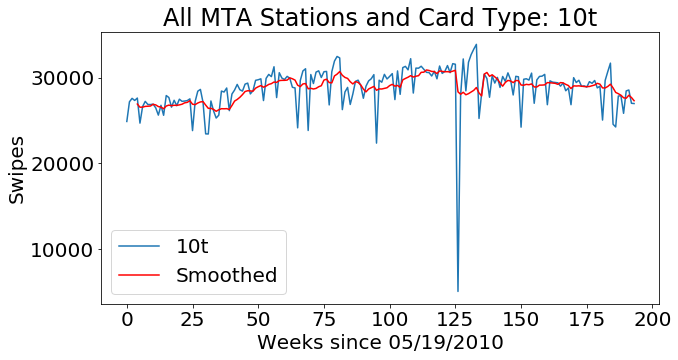

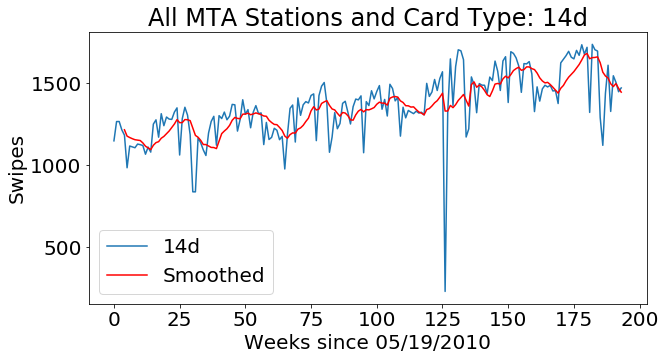

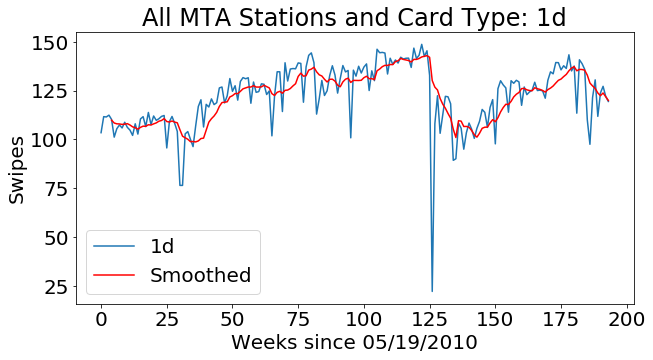

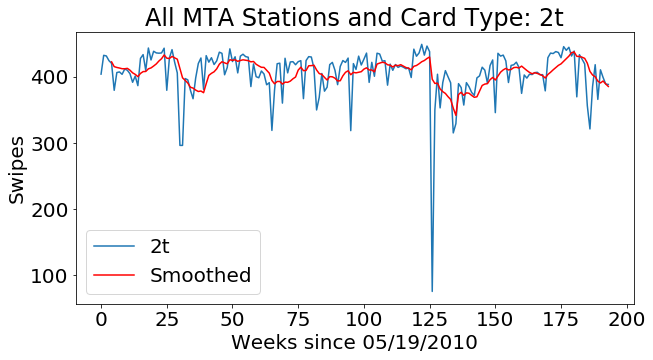

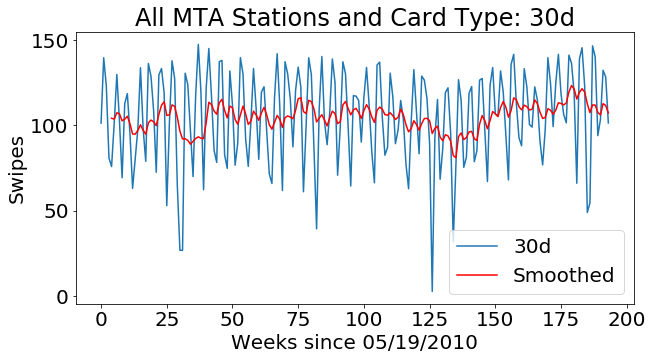

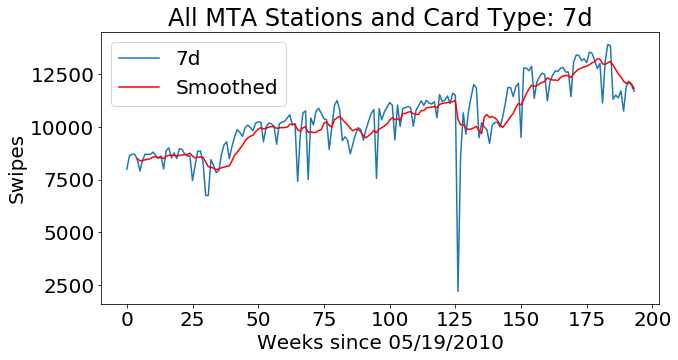

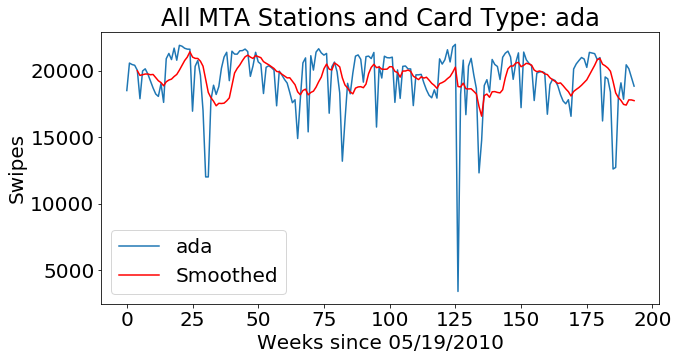

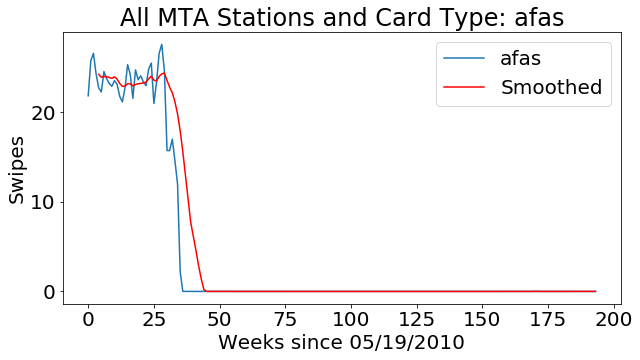

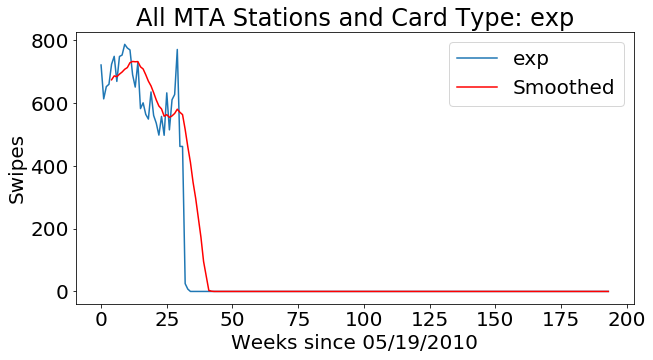

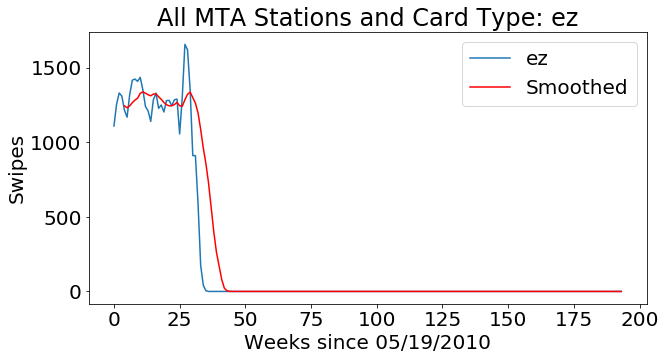

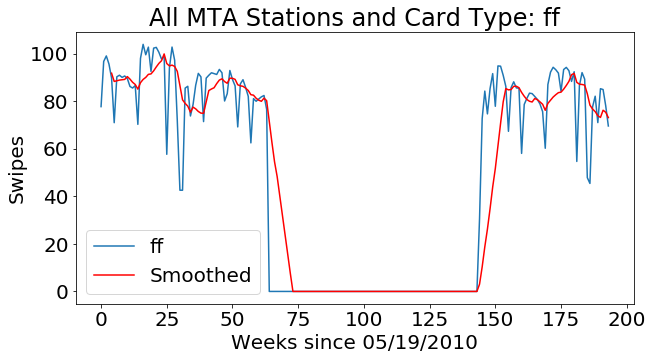

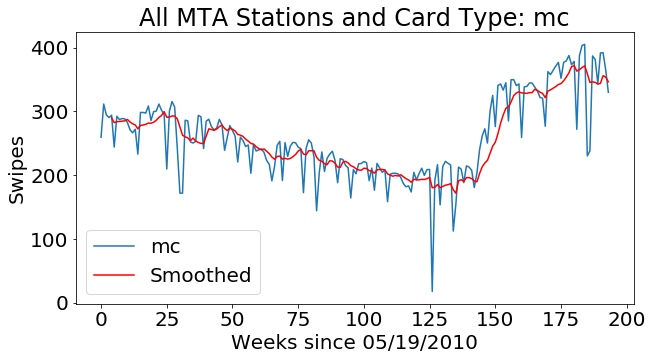

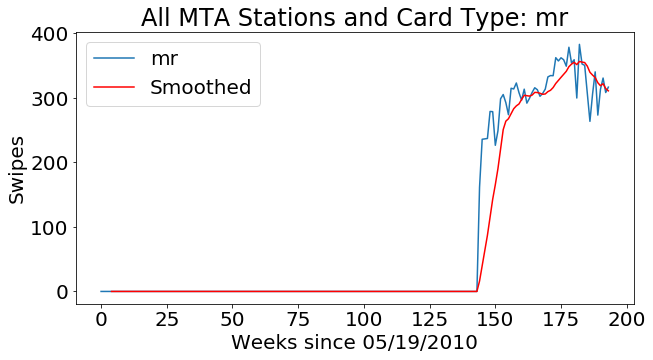

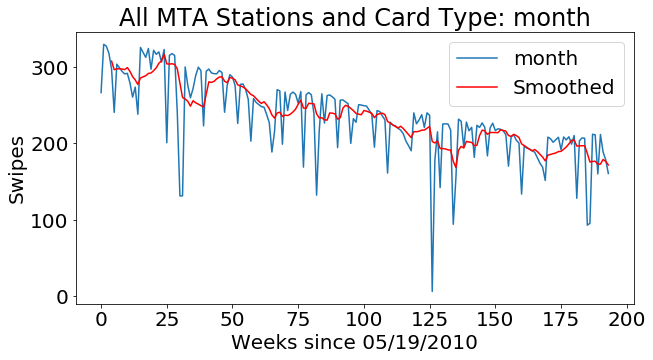

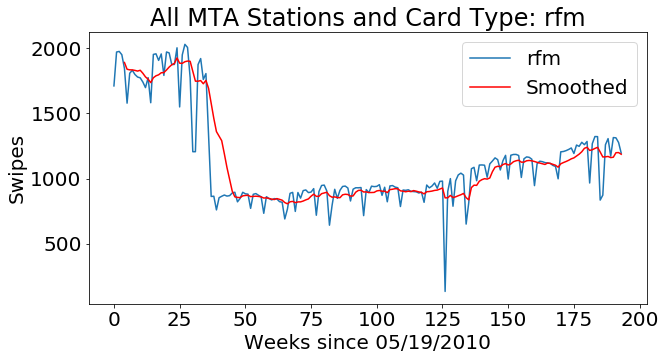

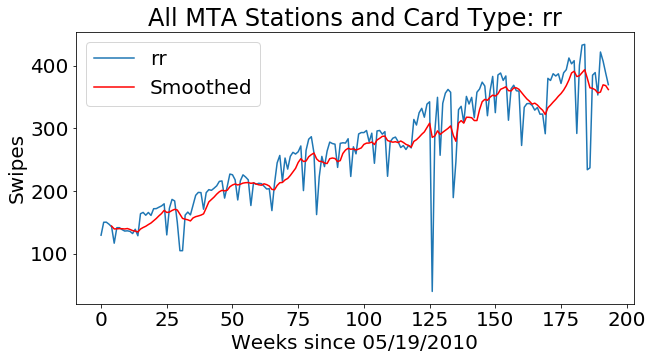

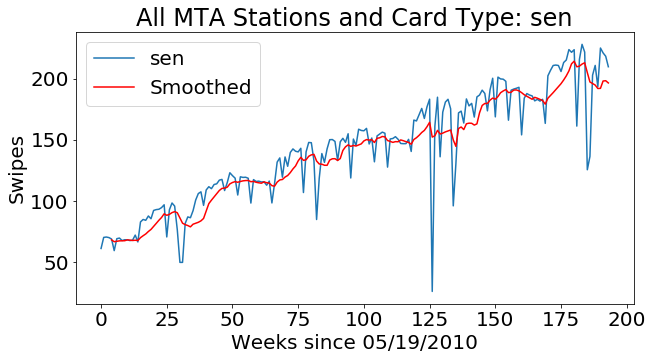

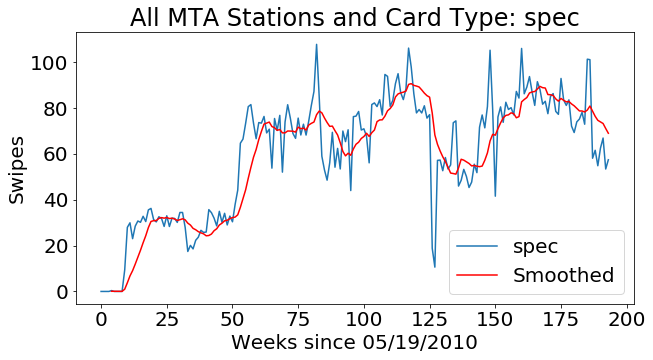

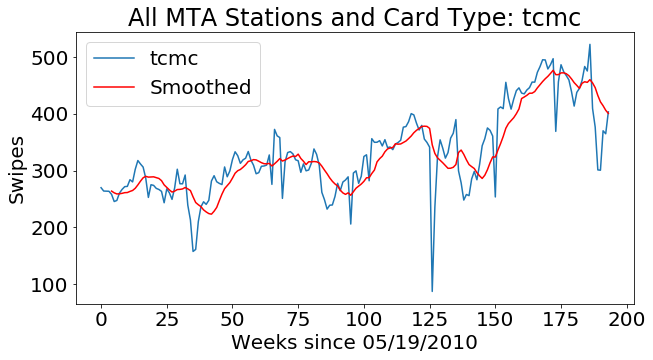

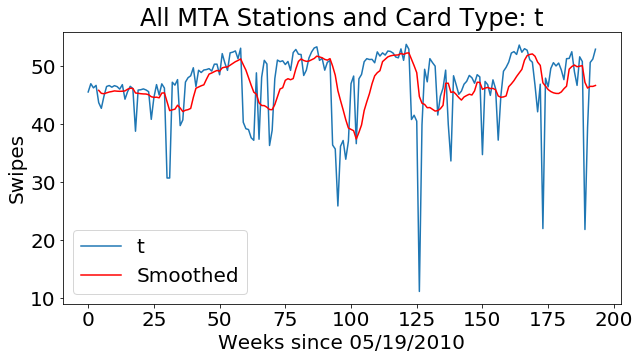

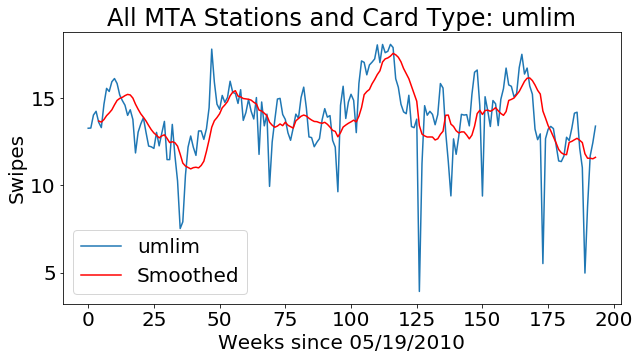

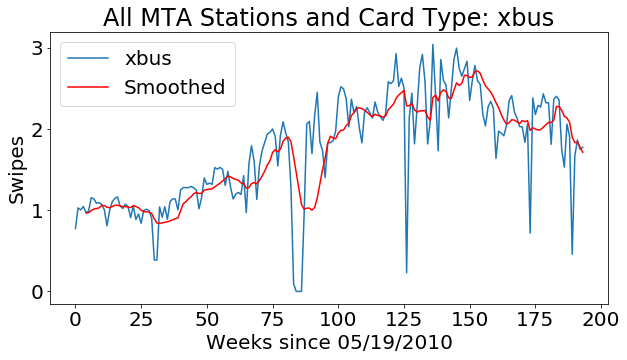

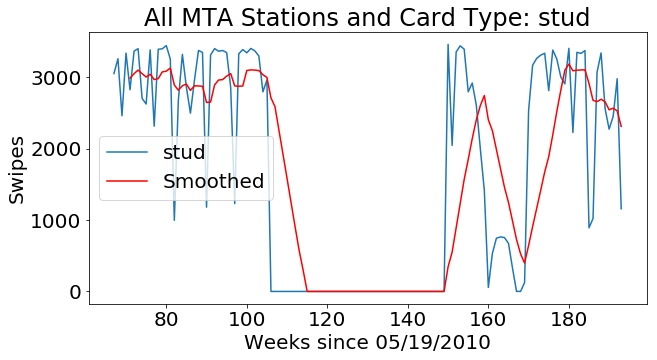

In [39]:
for i in ridetype:
    plt.figure(figsize=(10,5))
    plt.plot(mta_ridetype_df[i])
    plt.plot(mta_ridetype_df_rolling[i], color='red', label='Smoothed')
    plt.ylabel("Swipes")
    plt.xlabel("Weeks since 05/19/2010")
    plt.legend()
    pl.title('All MTA Stations and Card Type: '+ i)

Figure 4: Overall plot of all 23 ridertypes' swipes across time. The presence of high magnitude data series have squeezed most of the lines to the lower portions of the graph, reducing visibility and ability to 'eyeball' the data. 

**Calculate ratio of usage in the first 10 and last 10 weeks**

In [25]:
# my code 
ratio = []
for i in range(0,22):
    ratio.append(sum(mta_ridetype[i][1:10])/sum(mta_ridetype[i][184:194])) #append stores output as an array

In [26]:
ratio

[0.88619162106947547,
 0.71815377390785917,
 0.81237600342575733,
 0.96463745369115961,
 0.87172264694254387,
 0.65094387208133198,
 1.0055579191771749,
 4330.8284981859579,
 83933.021756425514,
 608182.92341637053,
 1.1133082737458484,
 0.74798916305976215,
 3.748617746415556e-05,
 1.570576096648679,
 1.3931979625628004,
 0.34936657587773617,
 0.31215487115238966,
 0.014223018219323634,
 0.58442854003644629,
 0.88003899707687672,
 1.1200358162988797,
 0.55547358889030995]

In [27]:
ratio[7:10]

[4330.8284981859579, 83933.021756425514, 608182.92341637053]

Further proof that series 7 to 10 in ridertypes have extremely high ratio of first 10 weeks' usage against last 10 weeks' ratio, as the ratio amounted to 4330, 83933 and 608182 respectively

In [97]:
ratio[12]

3.748617746415556e-05

Series 13 seems to have the next highest ratio 

**Steepest increase/decrease**

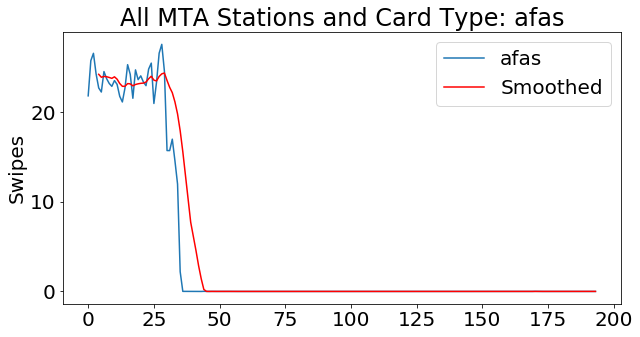

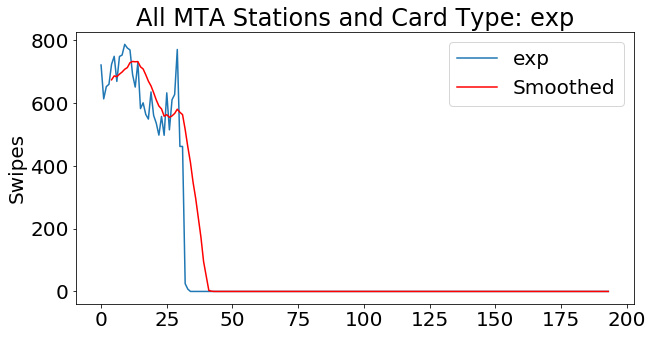

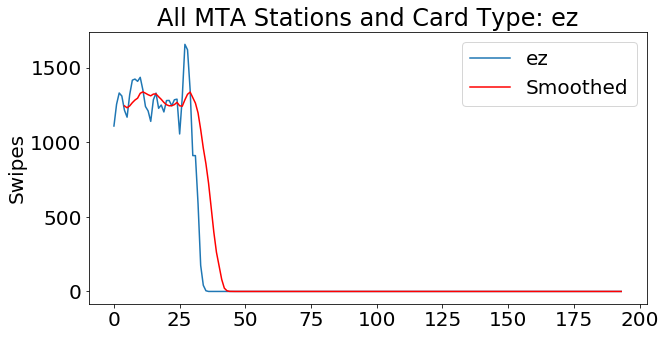

In [100]:
for i in ridetype[7:10]:
    plt.figure(figsize=(10,5))
    plt.plot(mta_ridetype_df[i])
    plt.plot(mta_ridetype_df_rolling[i], color='red', label='Smoothed')
    plt.ylabel("Swipes")
    plt.legend()
    pl.title('All MTA Stations and Card Type: '+ i)

Figure 5: The steepest decrease of all 23 card time across time are of card types afas, exp and ez. It seems like the card types was terminated after period 30. 

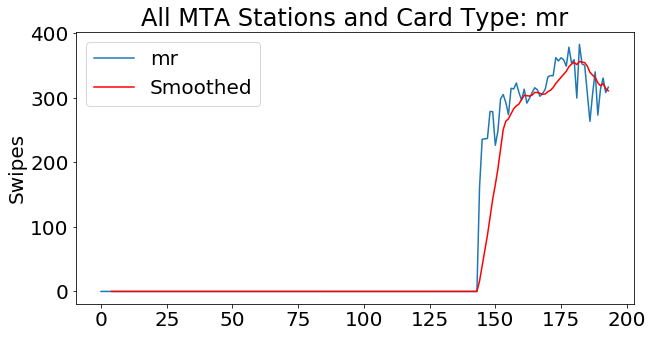

In [102]:
#Series 13 is a special mention it is the 4th highest ratio
for i in ridetype[12:13]:
    plt.figure(figsize=(10,5))
    plt.plot(mta_ridetype_df[i])
    plt.plot(mta_ridetype_df_rolling[i], color='red', label='Smoothed')
    plt.ylabel("Swipes")
    plt.legend()
    pl.title('All MTA Stations and Card Type: '+ i)

Figure 6: The steepest increase of all 23 card time across time are of card types afas, exp and ez. It seems like the card types was put into service after period 140. 

# Task 3

Build a classifier that assigns a card type to a time series based on time series features

Build models that classified the ride type based on the time series characteristics using random forests.
Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model

Build one that uses as input features the following engineered features :
the time series mean divided by the mean of all time series for that station
the time series standard deviation by the standard deviation of all time series for that station
the slope and intercept of a line fit to the standardized time series
  (time_series - time_series.mean())/time_series.std()

**Removing NaN**

In [42]:
stations_time = np.nansum(mta_float, axis=1)
stations_time.shape

(600, 194)

In [43]:
stations_mean = np.nanmean(stations_time, axis=1)
stations_mean.shape

(600,)

In [44]:
stations_std = np.nanstd(stations_time, axis=1)
stations_std.shape

(600,)

In [45]:
# remove nans in station id
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationidclean = stationid[mta_float.reshape(600*23, 194).std(axis=1) > 0] #sorting by the std actually helps to drop NaN
stationidclean.shape

(7660,)

In [46]:
# remove nans in rider type
rtypeid = np.concatenate(np.repeat([np.array(range(23))], 600, axis=0))
rtypeidclean = rtypeid[mta_float.reshape(600*23, 194).std(axis=1) > 0]
rtypeidclean.shape

(7660,)

In [47]:
tots = []

for i in range(0,len(rtypeidclean)):
    tots.append(mta[stationidclean[i]][rtypeidclean[i]])

In [48]:
tots = np.asarray(tots)
tots.shape

(7660, 194)

In [49]:
normed_time_series = []

for i in range(len(rtypeidclean)):
    normed_time_series.append((tots[i] - tots[i].mean())/tots[i].std())

normed_time_series = np.asarray(normed_time_series)
normed_time_series.shape

(7660, 194)

In [50]:
normed_time_series_mean = normed_time_series.mean(axis=1)
normed_time_series_std = normed_time_series.std(axis=1)

In [73]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape

(7660,)

In [80]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev.shape

(7660,)

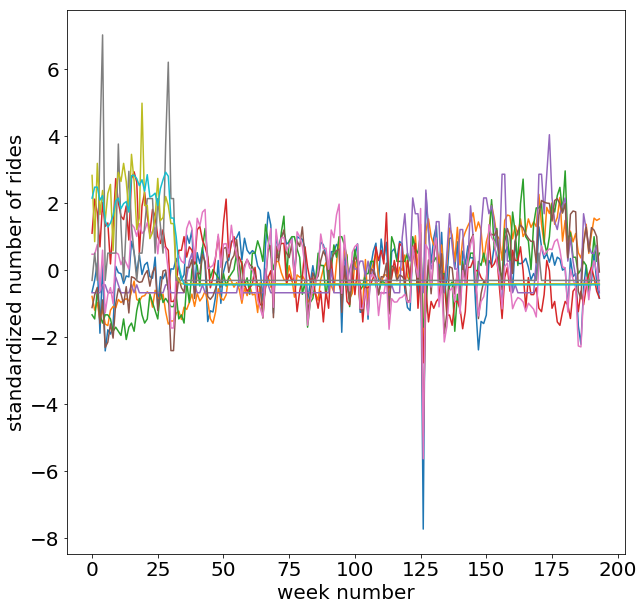

In [92]:
standardizedts = normed_time_series

pl.figure(figsize=(10,10))

for i in range(10):
    pl.plot(standardizedts[i])
    pl.xlabel("week number")
    pl.ylabel("standardized number of rides");